In [82]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from PIL import Image
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
kids_puzzles_url = 'https://www.trefl.com/puzzle/dla-dzieci?product_list_limit=all'
adults_puzzles_url = 'https://www.trefl.com/puzzle/dla-doroslych?product_list_limit=all'

In [2]:
def get_links(content):
    soup = BeautifulSoup(content, 'html.parser')
    puzzles_list = soup.find('body')
    puzzles_list_items = puzzles_list.find('ol')
    list_items = puzzles_list_items.find_all('li')
    links = []

    for puzzles in list_items:
        a = puzzles.select_one('a')
        if 'href' in a.attrs:
            link_url = a.get('href')
        links.append(link_url)
    return links

In [3]:
def get_list_of_images_and_age_categories(links):
    excluded_keywords = ['panoramiczne', 'drewniane', 'Megabox']
    image_and_category_dict = {}
    invalid_links = []
    if len(image_and_category_dict) / 50 == 0:
                    print(f'Dict have {len(image_and_category_dict)} items.')
    for link in links:
        response = requests.get(link)
        html_content = response.text
        soup = BeautifulSoup(html_content, "html.parser")

        try:
            keywords = soup.find('meta', attrs={'name': 'keywords'})['content']
        except Exception as e:
            print(f'{e} in link: {link}')
        else:
            if any([keyword in keywords for keyword in excluded_keywords]):
                continue
        
            elements = soup.find_all('div', class_ = 'product-content__img')
            category = soup.find_all('div', class_ = 'c-product-attributes')
            years = BeautifulSoup(str(category[0])).div   
            if len(category) > 1:
                years = BeautifulSoup(str(category[1])).div           
            tag = BeautifulSoup(str(elements[0])).div
            try:
                tag_content = tag.img['src']
                years_content =  re.split(r"([0-9]+)", years.img['src'])[-2]
            except Exception as e:
                invalid_links.append(link)
                print(f'{e} in link: {link}')
            else:
                image_and_category_dict[tag_content] = years_content
    return image_and_category_dict, invalid_links


In [72]:
first_batch_of_links = get_links((requests.get(kids_puzzles_url)).text)
second_batch_of_links = get_links((requests.get(adults_puzzles_url)).text)

In [97]:
print(len(first_batch_of_links))
print(len(second_batch_of_links))
all_links = first_batch_of_links + second_batch_of_links
print(len(all_links))

332
351
683


In [98]:
image_and_category_dict, bad_links = get_list_of_images_and_age_categories(all_links)
img_response = requests.get(list(image_and_category_dict.keys())[0], stream=True)
img = Image.open(img_response.raw)
img.show()

Dict have 0 items.
'NoneType' object is not subscriptable in link: https://www.trefl.com/w-swiecie-transformers-23024
'NoneType' object is not subscriptable in link: https://www.trefl.com/urocze-bobaski-31414
'src' in link: https://www.trefl.com/sorter-kolorow-93162
'NoneType' object is not subscriptable in link: https://www.trefl.com/treflikowy-dzien-93166
'NoneType' object is not subscriptable in link: https://www.trefl.com/farma-44000
'NoneType' object is not subscriptable in link: https://www.trefl.com/zabawny-swiat-binga-93165
'NoneType' object is not subscriptable in link: https://www.trefl.com/zabawy-peppy-93164
'src' in link: https://www.trefl.com/rybka-minimini-36125
'NoneType' object is not subscriptable in link: https://www.trefl.com/bohaterski-spider-man-34384
'NoneType' object is not subscriptable in link: https://www.trefl.com/niezwyciezeni-avengersi-17357
'NoneType' object is not subscriptable in link: https://www.trefl.com/minionki-w-akcji-13264
'NoneType' object is not

In [99]:
len(image_and_category_dict)

484

In [100]:
len(bad_links)

38

In [101]:
for key, value in image_and_category_dict.items():
    if not os.path.exists(value):
        os.makedirs(value)
    response = requests.get(key)
    image_name = f"{key.split('/')[-1]}.png"
    image_path = os.path.join(value, image_name)
    image = response.content
    with open (image_path, 'wb') as file:
        file.write(image)

### Model

In [2]:
main_path = f'{os.getcwd()}\images'
image_size = (500, 500)

image_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0,
    validation_split = 0.2
)

In [3]:
X_train = image_generator.flow_from_directory(
    directory= main_path,
    target_size= image_size,
    batch_size= 16,
    subset= 'training'
)

Found 386 images belonging to 11 classes.


In [4]:
X_val = image_generator.flow_from_directory(
    directory= main_path,
    target_size= image_size,
    batch_size= 16,
    subset= 'validation'
)

Found 92 images belonging to 11 classes.


In [65]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation= 'relu', input_shape = (500, 500, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation= 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(11, activation= 'softmax')
])

In [66]:
model.compile(optimizer= 'adam',
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

In [67]:
custom_model_history = model.fit(X_train, epochs= 20, validation_data= X_val)

Epoch 1/20


c:\Users\kzadk\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 16s 601ms/step - loss: 3.3582 - accuracy: 0.3679 - val_loss: 1.7987 - val_accuracy: 0.3152
Epoch 2/20
25/25 [==============================] - 15s 593ms/step - loss: 1.2617 - accuracy: 0.5959 - val_loss: 1.5461 - val_accuracy: 0.4891
Epoch 3/20
25/25 [==============================] - 15s 613ms/step - loss: 0.7790 - accuracy: 0.7461 - val_loss: 1.6362 - val_accuracy: 0.4783
Epoch 4/20
25/25 [==============================] - 15s 598ms/step - loss: 0.3427 - accuracy: 0.9067 - val_loss: 1.6036 - val_accuracy: 0.5543
Epoch 5/20
25/25 [==============================] - 16s 617ms/step - loss: 0.0683 - accuracy: 0.9922 - val_loss: 2.0180 - val_accuracy: 0.5652
Epoch 6/20
25/25 [==============================] - 15s 603ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 2.3502 - val_accuracy: 0.5761
Epoch 7/20
25/25 [==============================] - 16s 623ms/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 2.1075 - val_accuracy: 0.5652
Epoch 8/20

### Pretrained ResNet50 model


In [30]:
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input

In [63]:
base_model = ResNet50(weights= 'imagenet', include_top = False, input_shape= (500, 500, 3))

for layer in base_model.layers:
    layer.trainable = False

flatten_layer = keras.layers.Flatten()(base_model.output)
dense_layer = keras.layers.Dense(128, activation = 'relu')(flatten_layer)
output_layer = keras.layers.Dense(11, activation= 'softmax')(dense_layer)

resnet_model = keras.models.Model(inputs = base_model.input, outputs = output_layer)

resnet_model.compile(optimizer= 'adam',
                     loss = 'categorical_crossentropy',
                     metrics= ['accuracy'])

resnet_model.fit(X_train, epochs= 5, validation_data= X_val)

for layer in base_model.layers:
    layer.trainable = True

resnet_model_history = resnet_model.fit(X_train, epochs= 20, validation_data= X_val)

Epoch 1/5
25/25 [==============================] - 86s 3s/step - loss: 72.0291 - accuracy: 0.2383 - val_loss: 44.3849 - val_accuracy: 0.3043
Epoch 2/5
25/25 [==============================] - 95s 4s/step - loss: 21.8146 - accuracy: 0.3731 - val_loss: 15.7189 - val_accuracy: 0.0652
Epoch 3/5
25/25 [==============================] - 95s 4s/step - loss: 9.4636 - accuracy: 0.4508 - val_loss: 8.7161 - val_accuracy: 0.4348
Epoch 4/5
25/25 [==============================] - 64s 3s/step - loss: 4.1505 - accuracy: 0.5181 - val_loss: 2.7175 - val_accuracy: 0.2500
Epoch 5/5
25/25 [==============================] - 67s 3s/step - loss: 2.0948 - accuracy: 0.3446 - val_loss: 2.5549 - val_accuracy: 0.2500
Epoch 1/20
25/25 [==============================] - 49s 2s/step - loss: 2.0301 - accuracy: 0.3782 - val_loss: 2.4523 - val_accuracy: 0.3261
Epoch 2/20
25/25 [==============================] - 49s 2s/step - loss: 2.2953 - accuracy: 0.2953 - val_loss: 2.3610 - val_accuracy: 0.2609
Epoch 3/20
25/25 [===

<Axes: >

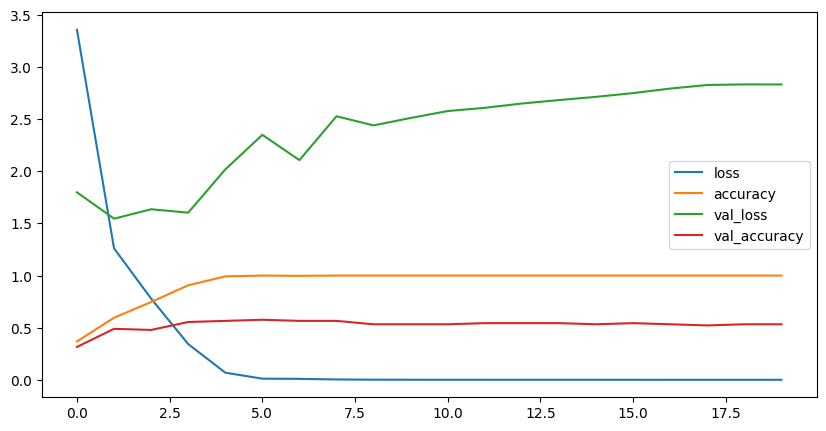

In [70]:
pd.DataFrame(custom_model_history.history).plot(figsize=(10, 5))

<Axes: >

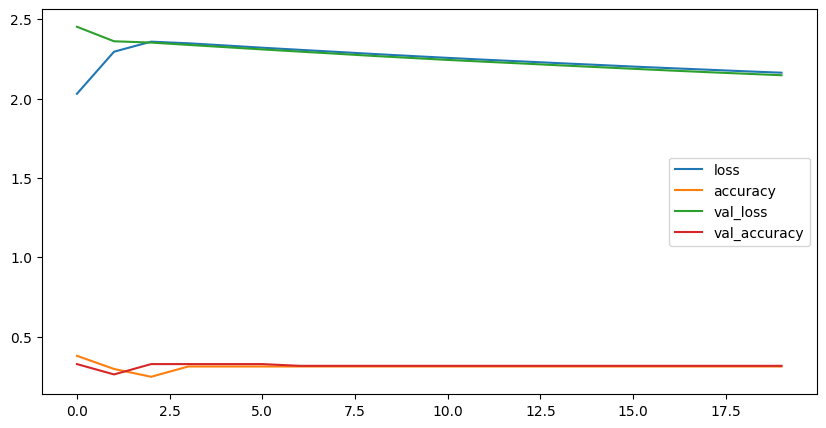

In [64]:
pd.DataFrame(resnet_model_history.history).plot(figsize=(10, 5))

## Same models but with regression

##### Custom model

In [26]:
reg_model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation= 'relu', input_shape = (500, 500, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation= 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

reg_model.compile(optimizer= 'adam',
              loss= 'mean_squared_error',
              metrics= ['mean_absolute_error'])

custom_reg_model_history = reg_model.fit(X_train,
                                         epochs= 10,
                                         validation_data= X_val)

Epoch 1/10


c:\Users\kzadk\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 17s 671ms/step - loss: 79.6598 - mean_absolute_error: 2.3685 - val_loss: 0.0867 - val_mean_absolute_error: 0.1228
Epoch 2/10
25/25 [==============================] - 16s 643ms/step - loss: 0.0870 - mean_absolute_error: 0.1862 - val_loss: 0.0845 - val_mean_absolute_error: 0.1320
Epoch 3/10
25/25 [==============================] - 16s 635ms/step - loss: 0.0839 - mean_absolute_error: 0.1655 - val_loss: 0.0829 - val_mean_absolute_error: 0.1569
Epoch 4/10
25/25 [==============================] - 16s 638ms/step - loss: 0.0831 - mean_absolute_error: 0.1629 - val_loss: 0.0828 - val_mean_absolute_error: 0.1611
Epoch 5/10
25/25 [==============================] - 20s 810ms/step - loss: 0.0829 - mean_absolute_error: 0.1642 - val_loss: 0.0828 - val_mean_absolute_error: 0.1641
Epoch 6/10
25/25 [==============================] - 26s 1s/step - loss: 0.0829 - mean_absolute_error: 0.1640 - val_loss: 0.0827 - val_mean_absolute_error: 0.1647
Epoch 7/10
25/25 [=====

<Axes: >

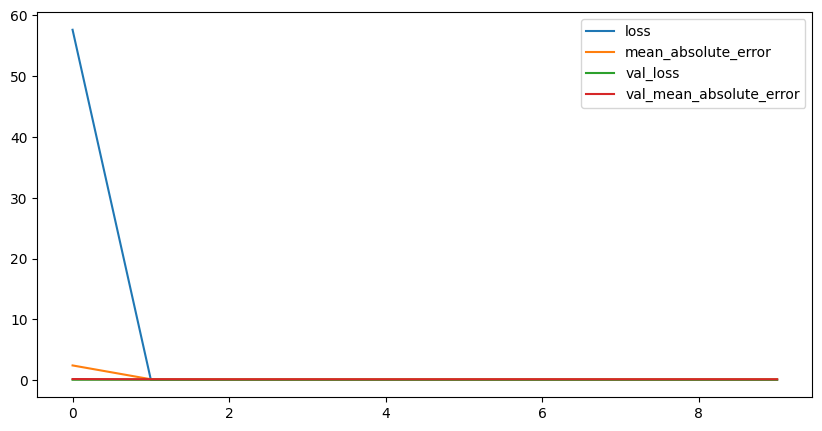

In [19]:
pd.DataFrame(custom_reg_model_history.history).plot(figsize=(10, 5))

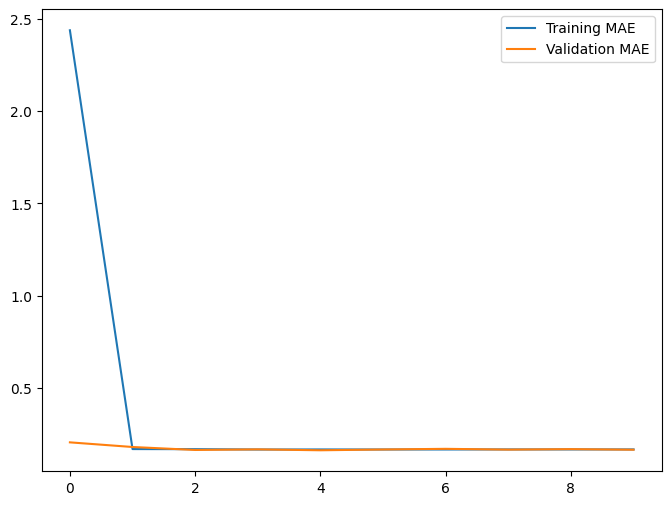

In [20]:
model_history = pd.DataFrame(custom_reg_model_history.history)
model_history['epoch'] = custom_reg_model_history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["mean_absolute_error"], 
        label="Training MAE")
ax.plot(np.arange(0, num_epochs), model_history["val_mean_absolute_error"], 
        label="Validation MAE")
ax.legend()

#### Pretrained model

In [48]:
base_model = ResNet50(weights= 'imagenet', include_top = False, input_shape= (500, 500, 3))

for layer in base_model.layers:
    layer.trainable = False

global_avg_pooling_layer = keras.layers.GlobalAveragePooling2D()(base_model.output)
output_layer = keras.layers.Dense(1)(global_avg_pooling_layer) 

resnet_reg_model = keras.models.Model(inputs = base_model.input, outputs = output_layer)

resnet_reg_model.compile(optimizer= 'adam',
                     loss = 'mean_squared_error',
                     metrics= ['mean_absolute_error'])

resnet_reg_model.fit(X_train, epochs= 5, validation_data= X_val)

for layer in base_model.layers:
    layer.trainable = True

resnet_reg_model_history = resnet_reg_model.fit(X_train, epochs= 10, validation_data= X_val)

Epoch 1/5


c:\Users\kzadk\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 42s 2s/step - loss: 0.4782 - mean_absolute_error: 0.5454 - val_loss: 0.1189 - val_mean_absolute_error: 0.3036
Epoch 2/5
25/25 [==============================] - 44s 2s/step - loss: 0.1086 - mean_absolute_error: 0.2121 - val_loss: 0.0888 - val_mean_absolute_error: 0.2023
Epoch 3/5
25/25 [==============================] - 44s 2s/step - loss: 0.0913 - mean_absolute_error: 0.1847 - val_loss: 0.0881 - val_mean_absolute_error: 0.1384
Epoch 4/5
25/25 [==============================] - 44s 2s/step - loss: 0.0870 - mean_absolute_error: 0.1724 - val_loss: 0.0862 - val_mean_absolute_error: 0.1503
Epoch 5/5
25/25 [==============================] - 44s 2s/step - loss: 0.0862 - mean_absolute_error: 0.1657 - val_loss: 0.0856 - val_mean_absolute_error: 0.1816
Epoch 1/10
25/25 [==============================] - 44s 2s/step - loss: 0.0855 - mean_absolute_error: 0.1709 - val_loss: 0.0851 - val_mean_absolute_error: 0.1684
Epoch 2/10
25/25 [=========================

<Axes: >

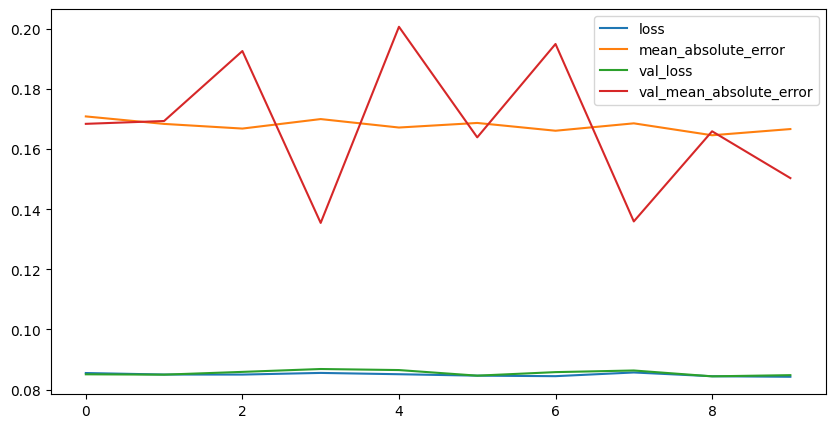

In [60]:
pd.DataFrame(resnet_reg_model_history.history).plot(figsize=(10, 5))

In [ ]:
# model.save(fr'{os.getcwd()}\models\Custom_classification_model')
# resnet_model.save(fr'{os.getcwd()}\models\Resnet_classification_model')
# reg_model.save(fr'{os.getcwd()}\models\Custom_regression_model')
# resnet_reg_model.save(fr'{os.getcwd()}\models\Resnet_regression_model')

In [28]:
loaded_regression_resnet_model = keras.models.load_model(fr'{os.getcwd()}\models\Resnet_regression_model')

In [68]:
import keras.utils as image

In [73]:
test_images_folder = fr'{os.getcwd()}\test'
test_images = []
for img in os.listdir(test_images_folder):
    img = os.path.join(test_images_folder, img)
    img = image.load_img(img, target_size = (500, 500))
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    test_images.append(img)

c:\Users\kzadk\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [74]:
print(test_images[0])

[[[[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  ...

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 

In [40]:
loaded_regression_resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 506, 506, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 250, 250, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [80]:
predict = loaded_regression_resnet_model.predict(test_images[0])

1/1 [==============================] - 0s 165ms/step


In [81]:
predict

array([[1.2949862]], dtype=float32)